## Ensemble solution

We've tried several options, but the one gave us best solution is just an ensemble of 20 sota baseline models with different seeds. We trained them with provided by competition authors train script. To save the time, in the notebook we just download trained checkpoints.

In [1]:
"""
TODO: wgetting checkpoints/installing the requirements
"""
import matplotlib.pyplot as plt
import seaborn as sns
from argparse import ArgumentParser
import os

# import warnings
# warnings.filterwarnings('ignore')
import torch
from torch import nn

from sensorium.utility import get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores
from sensorium.models.model_initialization import sota, SotaEnsemble
from sensorium.datasets.dataset_initialization import init_loaders
from sensorium.models.model_initialization import init_model
from sensorium.utility import submission
from nnfabrik.builder import get_data
from nnfabrik.builder import get_model



In [2]:
def init_loaders(basepath, **kwargs):
    # as filenames, we'll select all 7 datasets
    filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]

    dataset_fn = 'sensorium.datasets.static_loaders'
    dataset_config = {
        'paths': filenames,
        'normalize': True,
        'batch_size': 128,
    }

    dataset_config.update(kwargs)

    dataloaders = get_data(dataset_fn, dataset_config)
    return dataloaders


In [6]:
def init_model(model_name, checkpoint_path, dataloaders, shifter=False):
    if model_name == 'generalization':
        model = sota(dataloaders, checkpoint_path, shifter=shifter)
    elif model_name == 'ensemble':
        # TODO change 42 to 62
        checkpoints = [f'{checkpoint_path}{n}.pth' for n in range(41, 62)]
        model = SotaEnsemble(dataloaders, checkpoints, shifter=shifter).cuda()
    else:
        raise ValueError(f'Unknown model {model_name}')
    return model


class SotaEnsemble(nn.Module):
    def __init__(self, dataloaders, checkpoint_paths, shifter):
        super().__init__()
        self.models = []
        # We need to register dull param
        # to make neurapredictors functions correctly assign the device
        self.param = nn.Parameter(torch.tensor([42.]))

        for path in checkpoint_paths:
            self.models.append(sota(dataloaders, path, shifter).cuda())

    def __call__(self, *args, **kwargs):
        return torch.mean(torch.stack([
            model(*args, **kwargs) for model in self.models
        ]), dim=0)


def sota(dataloaders, checkpoint_path, shifter):
    model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
    model_config = {
        'pad_input': False,
        'layers': 4,
        'input_kern': 9,
        'gamma_input': 6.3831,
        'gamma_readout': 0.0076,
        'hidden_kern': 7,
        'hidden_channels': 64,
        'depth_separable': True,
        'grid_mean_predictor': {
            'type': 'cortex',
            'input_dimensions': 2,
            'hidden_layers': 1,
            'hidden_features': 30,
            'final_tanh': True
        },
        'init_sigma': 0.1,
        'init_mu_range': 0.3,
        'gauss_type': 'full',
        'shifter': shifter,
        'stack': -1,
    }

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=42,)

    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model


def benchmark(dataloaders, model, tier='validation', show_feves=False):
    correlation_to_average = get_signal_correlations(
        model, dataloaders, tier=tier, device="cuda", as_dict=True
    )

    measure_attribute = "Correlation to Average"
    df = get_df_for_scores(
        session_dict=correlation_to_average,
        measure_attribute=measure_attribute,
    )
    print(df[measure_attribute].mean())
    fig = plt.figure(figsize=(15,8))
    sns.boxenplot(x="dataset", y=measure_attribute, data=df, )
    plt.xticks(rotation = 45)
    sns.despine(trim=True)
    plt.show()

    if show_feves:
        feves = get_fev(model, dataloaders, tier="test", device="cuda", as_dict=True)
        measure_attribute = "FEVE"
        df = get_df_for_scores(
            session_dict=feves,
            measure_attribute=measure_attribute,
        )

        fig = plt.figure(figsize=(15, 8))
        sns.boxenplot(x="dataset", y=measure_attribute, data=df, )
        plt.xticks(rotation=45)
        plt.ylim([-.1, 1])
        sns.despine(trim=True)
        plt.show()



In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({
    'plus': True,
    'model': 'ensemble',
    'checkpoint_path': 'model_checkpoints/generalization_model_plus',
    'note': 'plus',
    'show_feves': False
})
print(args.plus)

True


/home/kirill/anaconda3/envs/sensorium/lib/python3.9/site-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/home/kirill/anaconda3/envs/sensorium/lib/python3.9/site-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
100%|█████████████████████████████████████████████| 7/7 [01:55<00:00, 16.55s/it]


0.38768682


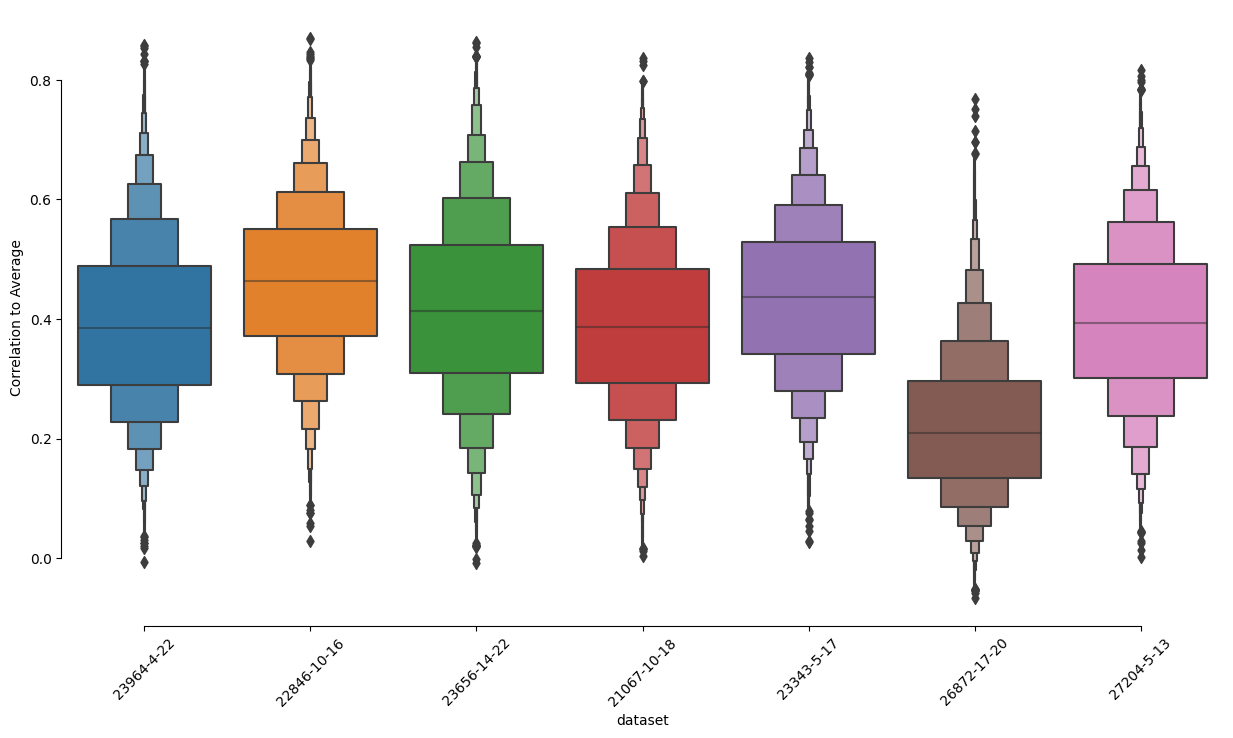

Submission file saved for tier: live_test. Saved in: ./submission_files/ensembleplus/submission_file_live_test.csv
Submission file saved for tier: final_test. Saved in: ./submission_files/ensembleplus/submission_file_final_test.csv


In [5]:
basepath = "./notebooks/data/"
dataloaders = init_loaders(
    basepath, scale=0.25, include_behavior=args.plus, include_eye_position=args.plus
)

model = init_model(args.model, args.checkpoint_path, dataloaders, shifter=args.plus)
benchmark(dataloaders, model, tier='validation', show_feves=args.show_feves)


save_directory = f"./submission_files/{args.model}{args.note}"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
# generate the submission file
if args.plus:
    dataset_name = '27204-5-13'
else:
    dataset_name = '26872-17-20'  
    
submission.generate_submission_file(
    trained_model=model,
    dataloaders=dataloaders,
    data_key=dataset_name,
    path=save_directory,
    device="cuda"
)
